# **`Import Libraries`**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder
# configure notebook to display plots
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


## Load Data

In [ ]:
df5 = pd.read_csv(r"/gdrive/MyDrive/MSCDiss/train.csv")

In [ ]:
df6 = pd.read_csv(r"/gdrive/MyDrive/MSCDiss/test.csv")

# Data Analysis

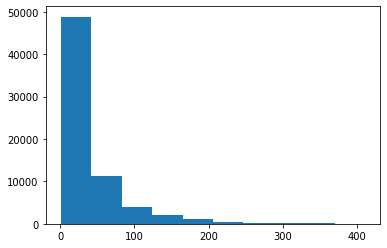

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = df5.subindex_n

plt.hist(x)
plt.show()

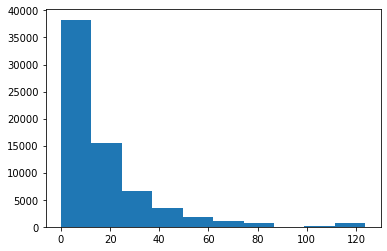

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = df5.los

plt.hist(x)
plt.show()

In [ ]:
df1=df5.loc[df5['los'] <=31 ]
df2=df6.loc[df6['los'] <=31 ]

In [ ]:
df1=df1.drop(['Unnamed: 0'],axis='columns')
df2=df2.drop(['Unnamed: 0'],axis='columns')
df1['news_date'] = pd.to_datetime(df1['news_date'])
df1['news_date'] = df1['news_date'].dt.hour
df2['news_date'] = pd.to_datetime(df2['news_date'])
df2['news_date'] = df2['news_date'].dt.hour

In [ ]:
df=df2.ID

In [ ]:
df1

In [ ]:
df2

In [ ]:
df1.set_index(['ID', 'news_date'], inplace=True)
df1

In [ ]:
df2.set_index(['ID', 'news_date'], inplace=True)
#df2

Rename the **male** column to **gender**
and use LabelEncoder to change the **cnsrespons** column to numerical .

In [ ]:
df1 = df1.rename(columns={'male': 'gender'})
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1["cnsresponse1"] = le.fit_transform(df1["cnsresponse"])
data1= df1.drop('cnsresponse',axis= 'columns' )

In [ ]:
df2= df2.rename(columns={'male': 'gender'})
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df2["cnsresponse1"] = le.fit_transform(df2["cnsresponse"])
data2= df2.drop('cnsresponse',axis= 'columns' )

In [ ]:
X_train=data1.drop(['admin_date',	'disch_date',	'died','hosp','NEWS1','subindex_n'],axis='columns')
y_train=data1.died

In [ ]:
X_test=data2.drop(['admin_date',	'disch_date',	'died','hosp','NEWS1','subindex_n'],axis='columns')
y_test=data2.died

In [ ]:
X_train

# Padding

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
maxlen = 150
# get a list of unique IDs
trainId = X_train.index.levels[0]


In [ ]:
# pad every patient sequence with 0
# transforms the list of sequences to numpy array
X_train = [X_train.loc[ID].values for ID in trainId]
y_train = [y_train.loc[ID].values for ID in trainId]

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train, maxlen=maxlen, padding='post', truncating='post')


In [ ]:
maxlen = 150
testId = X_test.index.levels[0]

In [ ]:
X_test = [X_test.loc[ID].values for ID in testId]
y_test = [y_test.loc[ID].values for ID in testId]

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='post',truncating='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(y_test, maxlen=maxlen, padding='post',truncating='post')


In [ ]:
y_train=y_train.reshape(y_train.shape[0],y_train.shape[1],1)
y_test=y_test.reshape(y_test.shape[0],y_test.shape[1],1)

In [ ]:
print("X_train shape: %s | y_train shape: %s" % (str(X_train.shape), str(y_train.shape)))
print("X_test shape: %s | y_test shape: %s" % (str(X_test.shape), str(y_test.shape)))

X_train shape: (1879, 150, 17) | y_train shape: (1879, 150, 1)
X_test shape: (611, 150, 17) | y_test shape: (611, 150, 1)


# Model

In [ ]:
from keras.layers import (
    Input,
    Dense,
    LSTM,
    GlobalAveragePooling1D,
    AveragePooling1D,
    TimeDistributed,
    Flatten,
    Bidirectional,
    Dropout,
    Masking,
    Layer,
    BatchNormalization
)
from keras.models import Model
from keras.optimizers import Adam,Nadam

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)


batch size of 128 which means that we update parameters every 128.
Use 100 training epochs, which means that we run through the data 100 times

In [ ]:
BATCH_SIZE = 128
N_EPOCHS = 100

In [ ]:
x = Input((X_train.shape[1],X_train.shape[2]) , name='input')
mask = Masking(0., name='input_masked')(x)
lstm = LSTM(128, name='lstm1', dropout=0.2,return_sequences= True)(mask)
# output: sigmoid layer
output =Dense(1, activation='sigmoid', name='output')(lstm)
model = Model(inputs = x, outputs = output)

# compile model
model.compile(optimizer=Nadam(learning_rate=0.005), loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 150, 17)]         0         
                                                                 
 input_masked (Masking)      (None, 150, 17)           0         
                                                                 
 lstm1 (LSTM)                (None, 150, 128)          74752     
                                                                 
 output (Dense)              (None, 150, 1)            129       
                                                                 
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
            batch_size=BATCH_SIZE, epochs=N_EPOCHS,
            validation_split=0.2 ,callbacks=[early_stopping])

Epoch 1/100
12/12 [==============================] - 17s 1s/step - loss: 0.2915 - accuracy: 0.9183 - val_loss: 0.3242 - val_accuracy: 0.8625
Epoch 2/100
12/12 [==============================] - 9s 776ms/step - loss: 0.2510 - accuracy: 0.9258 - val_loss: 0.3343 - val_accuracy: 0.8625
Epoch 3/100
12/12 [==============================] - 4s 378ms/step - loss: 0.2418 - accuracy: 0.9257 - val_loss: 0.3469 - val_accuracy: 0.8625
Epoch 4/100
12/12 [==============================] - 5s 389ms/step - loss: 0.2369 - accuracy: 0.9267 - val_loss: 0.3433 - val_accuracy: 0.8625
Epoch 5/100
12/12 [==============================] - 6s 445ms/step - loss: 0.2383 - accuracy: 0.9268 - val_loss: 0.3307 - val_accuracy: 0.8640
Epoch 6/100
12/12 [==============================] - 4s 370ms/step - loss: 0.2292 - accuracy: 0.9263 - val_loss: 0.3162 - val_accuracy: 0.8686
Epoch 7/100
12/12 [==============================] - 6s 486ms/step - loss: 0.2333 - accuracy: 0.9267 - val_loss: 0.3689 - val_accuracy: 0.8626
E

In [ ]:
preds = model.predict(X_test)

20/20 [==============================] - 2s 59ms/step


In [ ]:
from sklearn.metrics import roc_curve, auc
# 0/1 binary lable for each patient
label = y_test[:, 0, :].squeeze();


In [ ]:
preds1= preds[:,-1,:].squeeze()

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(label,preds1)
lstm_auc = metrics.auc(fpr, tpr)
print('ACU:',lstm_auc)

ACU: 0.9460068259385666
